# 0 Testing environment for Python
This is a testing environment, to elaborate methods and functions for the rersearch paper containing CCT computing resp. simulation.

## 0.1 Trying to reproduce a SMIB model

Testing / reproducing of a SMIB model after [Georg Kordowich](https://medium.com/@georg.kordowich/watts-up-with-dynamic-power-system-simulations-c0f16fc99769), therrefore using the already improved version with Heun's method for solving the numerical problem.
Supporting files and documentation can be found on [GitHub](https://github.com/georgkordowich/smib-simulation):

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
from scipy.integrate import odeint

import simulation_gk as s

Defining all relavnt parameters and variables:

In [2]:
# Define the parameters of the system
fn = 60
H_gen = 3.5
X_gen = 0.2
X_ibb = 0.1
X_line = 0.65

# Values are initialized from loadflow
E_fd_gen = 1.075
E_fd_ibb = 1.033
P_m_gen = 1998/2200

# init states of variables
omega_gen_init = 0 # init state
delta_gen_init = np.deg2rad(45.9) # init state
delta_ibb_init = np.deg2rad(-5.0) # init state

# v_bb_gen_init = mag_and_angle_to_cmplx(1.0, np.deg2rad(36.172))

# -> How can these variables set globally in the Jupyter script or in the different modules?

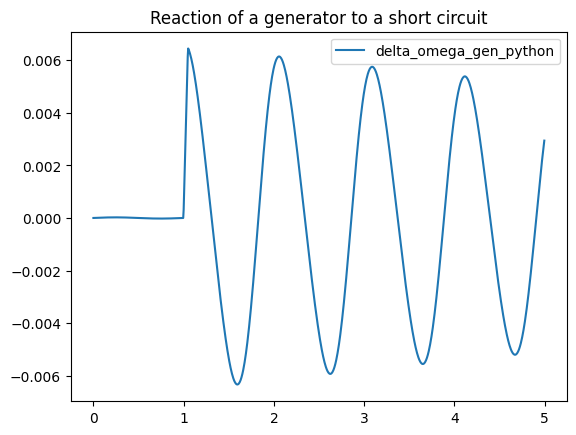

In [3]:
# Here the simulation is executed and the timesteps and corresponding results are returned.
# In this example, the results are omega, delta, e_q_t, e_d_t, e_q_st, e_d_st of the generator and the IBB
t_sim, res_omega, res_delta = s.do_sim()

# calculate the solution with python internal solving methods (e.g. odeint)


# load the results from powerfactory for comparison
# delta_omega_pf = np.loadtxt('pictures/powerfactory_data.csv', skiprows=1, delimiter=',')


# Plot the results
plt.plot(t_sim, res_omega[:, 0].real, label='delta_omega_gen_python')
# plt.plot(delta_omega_pf[:, 0], delta_omega_pf[:, 1] - 1, label='delta_omega_gen_powerfactory')
plt.legend()

plt.title('Reaction of a generator to a short circuit')

plt.show()

In [4]:
# calculating the average mean error (absolute and relative) vs. powerfactory

# def error_abs(array1, array2):
#     # returning the cumulated, over a time period normalized, mean absolute error in rad
#     n_timesteps = np.size(array1)
#     error_cum = 0

#     for i in range(n_timesteps-1):
#         error_cum = error_cum + np.abs((array1[i] - 1) - array2[i])

#     error_abs = error_cum/n_timesteps
#     return error_abs

# def error_rel(array1, array2):
#     # returning the cumulated, over a time period normalized, mean relative error
#     n_timesteps = np.size(array1) # how many single errors; altought not working when size(array1) != size(array2)
#     error_cum = 0

#     # adding the singel errors up
#     for i in range(n_timesteps-1):
#         error_cum = error_cum + np.abs(1 - (array1[i] - 1)/array2[i])

#     error_rel = error_cum/n_timesteps
#     return error_rel

# print('abs error: ' + str(round(np.rad2deg(error_abs(delta_omega_pf[:, 1], res_omega[:, 0].real)), 6)) + ' grad')
# print('rel error: ' + str(round(error_rel(delta_omega_pf[:, 1], res_omega[:, 0].real)*100, 2)) + ' %')

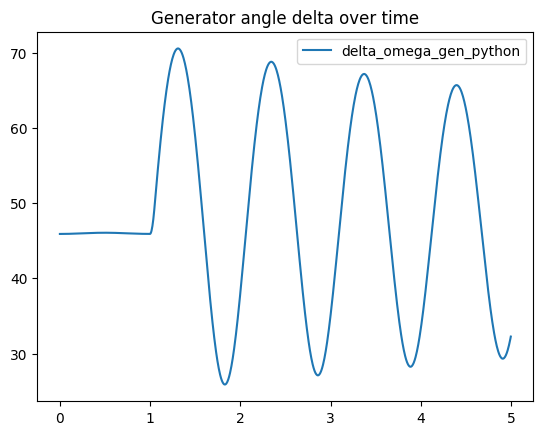

In [5]:
plt.plot(t_sim, np.rad2deg(res_delta), label='delta_omega_gen_python')
plt.legend()
plt.title('Generator angle delta over time')
plt.show()

## 0.2 Comparison to pythons solution

Solving the differential equation with Python build-in *odeint()* solvers. Comparing it to the others.

-> Possible? Or self implementing of Runge-Kutta, Predictor-Corrector, ...

In [6]:
# # pre-definitions
# t = np.arange(0, 5, 0.005)

# # Define the parameters of the system
# fn = 60
# H_gen = 3.5
# X_gen = 0.2
# X_ibb = 0.1
# X_line = 0.65

# # Values are initialized from loadflow
# E_fd_gen = 1.075
# E_fd_ibb = 1.033
# P_m_gen = 1998/2200

# omega_gen_init = 0
# delta_gen_init = np.deg2rad(45.9)
# delta_ibb_init = np.deg2rad(-5.0)

# v_bb_gen_init = s.mag_and_angle_to_cmplx(1.0, np.deg2rad(36.172))

# # function representing the ode
# def tsa(s.ode_gen(), ,t):
#     return [result_odeint[0], 1/(2*H_gen)*(T_m_gen - P_e_gen)]

P_e_gen_ode = []

# setting up T_m_gen in relation to time
for i in range(np.size(t_sim)-1):
    if 1/0.005 <= i < 1.10/0.005:
        P_e_gen_ode[i] = 0
    else:
        P_e_gen_ode[i] = P_m_gen

# solving with initial conditions. machine parameters and time frame from above
ddelta_odeint, domega_odeint = odeint(s.ode_gen, [np.deg2rad(45.9), 0], t_sim).T
print(ddelta_odeint)

# # plt.plot(t_sim, res_omega[:, 0].real, label='delta_omega_gen_python')
# plt.plot(t_sim, domega_odeint, label='delta_omega_gen_odeint')
# plt.legend()

# plt.title('Comparison delta_omega odeint vs. Heun')

# plt.show()

IndexError: list assignment index out of range

# 1 CCT elaboration of synchronous generators

This jupyter notebook contains a single machine model for the simulation of a single synchronous generator.
With this notebook-type programming the readability and documentation of the model and thinking shall be improved in relation to a normal and standalone python script / program.

## 1.1 Computing the EAC for determing the CCT

Before we modelled the behavior of single synchronous machine against a fixed electrical bus (called SMIB model). Now we want to calculate the CCT from that and further determine if the machine is still running in stable operation.

### SMIB-Model

### EAC calculation

## 1.2 Using .csv-files as mini-storage

.csv-files shall be used as documentation / storage. Therefore functions shall be created to store datasets of CCT experiments.

File-Writing and Read-Out is observed necessary.

## 1.3 Plotting of results

Functions / A Library shall be created to easily create plots out of stored data.

# 2 Further investigation

## 2.1 Setting up of test cases

Test case scenarios (different observation boundaries / operation conditions) shall be created. On top a testing matrix for a small parameter testing is mandatory.

## 2.2 Inverse calculation (optimization)

Trying to implement an inverse calculation (operation conditions / boundaries -> minimal machine requirements), can be seen as "optimization".

# 3 Non-elaborated influences

- damping part in every machine
- machine networks and fault with large line distance to the generator(s); esp. with high-interconnected highest-voltage networks -> complex behaviors
- stability behavior of other generators and their influence on the examined machine